<a href="https://colab.research.google.com/github/Modinat-A/DeepLearning/blob/main/Deep_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import scipy.io
import torch.nn as nn
import torch.nn.functional as F
import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# load EEG data
mat = scipy.io.loadmat('/content/drive/My Drive/WLDataCW.mat')
# get X
data = mat.get('data')
row,columns,samples = data.shape # number of channels features x data point  x  samples
print(row,columns,samples)

62 512 360


In [ ]:
# Get labels
labels = mat.get('label')
labels = labels.T
print(labels.shape)

(360, 1)


# Data Preprocessing

In [ ]:
#flatten data 
data= data.T
data=data.flatten().reshape(data.shape[0],data.shape[1] * data.shape[2])
scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaled = scaler.fit_transform(data)
data = x_scaled
print(data.shape)

(360, 31744)


[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 1.23988281e+02
 1.23992188e+02 1.23996094e+02]


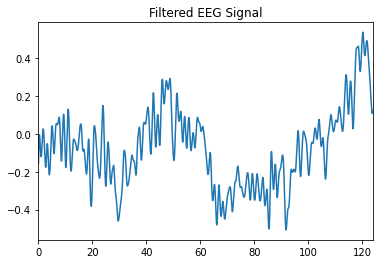

In [ ]:
# filtered data
datal = data[:1][0]
# read ECG data from the WAV file
times = np.arange(len(datal))/256
print(times)
# apply a 3-pole lowpass filter at 0.1x Nyquist frequency
b, a = scipy.signal.butter(3, 0.01)
filtered = scipy.signal.filtfilt(b, a, datal)
plt.plot(times, filtered)
plt.title("Filtered EEG Signal")
plt.margins(0, .05)
plt. savefig('loss.pdf')

In [ ]:
c = np.abs(np.fft.rfft(data))
c.shape

(360, 15873)

In [ ]:
c = np.abs(np.fft.rfft(c))
c.shape

(360, 7937)

In [ ]:
c = np.abs(np.fft.rfft(c))
c.shape

(360, 3969)

In [ ]:
data = c

In [ ]:
data.shape

(360, 3969)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaled = scaler.fit_transform(data)
data = x_scaled
print(data.shape)

(360, 3969)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
print('Number of training samples is',len(X_train), 'and shape is', X_train.shape )
print('Number of testing samples is',len(X_test),'and shape is', X_test.shape )
print('Number of training samples is',len(y_train), 'and shape is', y_train.shape )
print('Number of testing samples is',len(y_test),'and shape is', y_test.shape )

Number of training samples is 252 and shape is (252, 3969)
Number of testing samples is 108 and shape is (108, 3969)
Number of training samples is 252 and shape is (252, 1)
Number of testing samples is 108 and shape is (108, 1)


In [ ]:
w = np.empty([X_train.shape[1],1])
w.fill(0.1) # number of elements in each sample x number of classes
b = np.array([0.1])
print(w.shape)

(3969, 1)


# Logistic Model

In [ ]:
# calculate forward propagation 
def forward_propagation(w,x,b):
    result = np.dot(w.T,x) + b
    y = 1/(1 + np.exp(-result))
    return y

def get_loss(truth,prediction):#print(truth)
    k = len(prediction[0])
    calculated_loss = - (np.sum((truth * np.log(prediction) ) + ((1 - truth) * np.log(1 - prediction))))
    return calculated_loss/k


# calculate backpropagation 
# Get the dervativate of w i.e change in l with respect to w
def back_propagation(x,w,b,prediction, truth,learning_rate=0.1):
    pl= prediction-truth
    dw = np.dot(x, pl.T)/len(prediction[0])
    db = np.sum(pl,axis=1)/ len(prediction[0])
    w = w - np.dot(learning_rate , dw)
    b = b - np.dot(learning_rate ,db)
    return w, b

In [ ]:
import sklearn as skl
epochs = 300
batch = 12
batch_size = X_train.shape[0]//batch
total_loss = []
total_acc = []
for i in range(epochs):
  for i in range(batch): 
    # validation data 
    val_X_train = X_train[i * batch_size: (i + 1) * batch_size]
    val_y_train = y_train[i * batch_size: (i + 1) * batch_size]

    # Prepare the training data: data from all other partitions
    x = np.concatenate([X_train[:i * batch_size], X_train[ (i + 1) * batch_size: ]], axis=0)
    y = np.concatenate([y_train[:i * batch_size], y_train[ (i + 1) * batch_size:]], axis=0)
    
    # Fp
    prediction = forward_propagation(w,x.T,b)
    w,b  = back_propagation(x.T,w,b,prediction,y.T)
    # evaluate loss using validation data, 
    prediction = forward_propagation(w,val_X_train.T,b)
    loss = get_loss(val_y_train.T,prediction)

    prediction = np.round(abs(prediction))
    prediction = prediction.T

    acc = skl.metrics.accuracy_score(val_y_train,prediction)
  print(loss)  
  total_loss.append(loss)
  total_acc.append(acc)


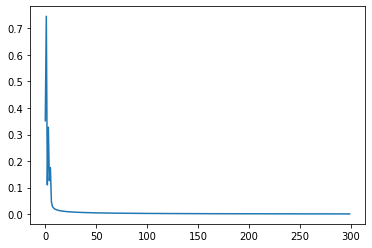

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(total_loss)
plt. savefig('loss.pdf')
plt.show()


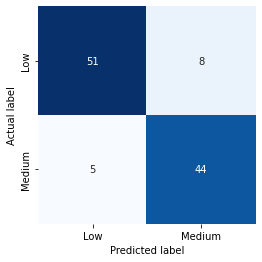

In [ ]:
prediction = forward_propagation(w,X_test.T,b)
prediction = np.round(abs(prediction))
prediction = prediction.T
y_predicted = prediction
mat = confusion_matrix(y_test, y_predicted)
labels = ['Low', 'Medium']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,cmap='Blues',
            xticklabels=labels, yticklabels=labels)


plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt. savefig('cm.pdf')

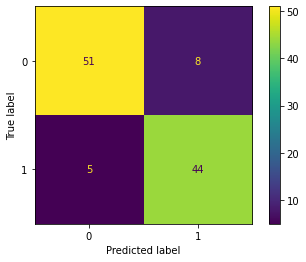

In [ ]:
prediction = forward_propagation(w,X_test.T,b)
prediction = np.round(abs(prediction))
prediction = prediction.T
cm = confusion_matrix(y_test, prediction)
disp = skl.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)  
disp.plot()
plt.show()

# Deep Learning Model

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn.model_selection import train_test_split
model = keras.Sequential([
                          keras.layers.Dense(64, activation=tf.nn.relu),
                          keras.layers.Dense(64, activation=tf.nn.relu),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(1, activation=tf.nn.sigmoid),
                          ])
model.compile(optimizer='adam',
          loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                batch_size=21,
                epochs=300,
                validation_data=(X_test, y_test))#,callbacks=callbacks)


test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                254080    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 258,305
Trainable params: 258,305
Non-trainable params: 0
_________________________________________________________________


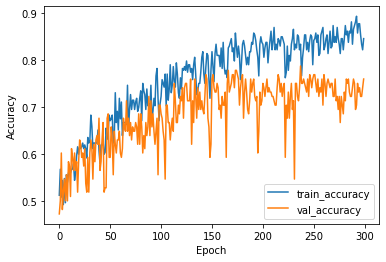

In [ ]:
# plot accuracy 
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

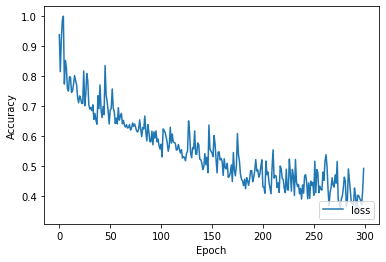

In [ ]:
# plot loss
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt. savefig('loss.pdf')

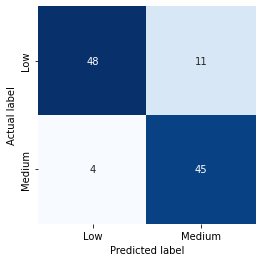

In [ ]:
y_predicted = model.predict(X_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Low', 'Medium']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,cmap='Blues',
            xticklabels=labels, yticklabels=labels)


plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt. savefig('cm.pdf')

# https://www.pluralsight.com/guides/deep-learning-model-perform-binary-classification
# Vaibhav Sharma
# 2019
# A Deep Learning Model to Perform Binary Classification

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Logistic Model', 'Deep Learning Model']
students = [23,75]
ax.bar(langs,students)
plt.show()